In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


# Define functions for pruning

In [150]:
# app = track_info['appearances']
def get_real_img_nums_dict(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]

    real_img_nums_dict = dict.fromkeys(range(batches))
    for batch in range(batches):
        real_img_nums_dict[batch] = {}

    # Gets number of real cells in each batch
    for batch in range(batches):
        print(batch)
        for cell in range(cells):
            if np.max(app[batch, 0, cell]) != 0:
                last_frame = 71
                for frame in range(frames):
                    if np.max(app[batch, frame, cell]) == 0:
                        last_frame = frame
                        break
                real_img_nums_dict[batch][cell] = last_frame
            else:
                break
    return real_img_nums_dict

In [3]:
def get_real_img_array(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    real_img_list = []
    real_img_nums_dict = get_real_img_nums_dict(app)
    for batch in range(batches):
        for cell in real_img_nums_dict[batch].keys():
            for frame in range(real_img_nums_dict[batch][cell]):
                real_img_list.append(app[batch][frame][cell])
    appearances = np.array(real_img_list)
    return appearances

In [4]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [5]:
def prepare_dataset(appearances, batch_size=1, buffer_size=256,
                    seed=None):
    app_shape = np.shape(appearances)

    # Appearances not being normalized yet (will have to slightly modify norm function
    # since we don't have this organized by life cycle
    appearances = norm(appearances)

    dataset = tf.data.Dataset.from_tensor_slices((appearances, appearances))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Load the train data

In [6]:
%%time
# data loading
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_train_trks = '/training/tracking-nuclear/train.trks'
    all_train_data = [load_trks(path_temp_train_trks)]
    
    all_train_tracks = [Track(tracked_data=d) for d in all_train_data]
    
    train_track_info = concat_tracks(all_train_tracks)
    
    train_appearances = get_real_img_array(train_track_info['appearances'])
    
    train_dataset = prepare_dataset(train_appearances, batch_size=100)

2022-07-20 21:29:05.708885: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 21:29:07.112685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
100%|███████████████████████████████████████████| 91/91 [11:20<00:00,  7.48s/it]
2022-07-20 21:51:32.656222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5645002080 exceeds 10% of free system memory.


CPU times: user 1h 25min 37s, sys: 1h 27min 12s, total: 2h 52min 50s
Wall time: 34min 4s


2022-07-20 22:03:06.798139: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2734931968 exceeds 10% of free system memory.
2022-07-20 22:03:08.286059: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2734931968 exceeds 10% of free system memory.


# Load the validation data

In [7]:
%%time
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/training/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    
    all_val_tracks = [Track(tracked_data=d) for d in all_val_data]
    
    val_track_info = concat_tracks(all_val_tracks)
    
    val_appearances = get_real_img_array(val_track_info['appearances'])
    
    val_dataset = prepare_dataset(val_appearances, batch_size=100)

100%|███████████████████████████████████████████| 27/27 [01:54<00:00,  4.25s/it]


CPU times: user 19min 36s, sys: 20min 22s, total: 39min 59s
Wall time: 7min 40s


# Define the model

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [74]:
class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(8*8*32, activation=None))
        layers.append(tfkl.Reshape((8,8,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [87]:
vae = VAE_MNIST(512, 1, 1e-3)

In [76]:
AE = vae.build_vae_keras_model()

In [77]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/dim_512'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3337/3339 [============================>.] - ETA: 0s - loss: -1388.8750
Epoch 1: val_loss improved from inf to -1489.57898, saving model to ../models/dim_512
3339/3339 [==============================] - 44s 12ms/step - loss: -1388.8772 - val_loss: -1489.5790 - lr: 0.0010
Epoch 2/15
3335/3339 [============================>.] - ETA: 0s - loss: -2035.4564
Epoch 2: val_loss improved from -1489.57898 to -1896.90344, saving model to ../models/dim_512
3339/3339 [==============================] - 40s 12ms/step - loss: -2034.9283 - val_loss: -1896.9034 - lr: 0.0010
Epoch 3/15
3338/3339 [============================>.] - ETA: 0s - loss: -2227.6204
Epoch 3: val_loss improved from -1896.90344 to -2052.07227, saving model to ../models/dim_512
3339/3339 [==============================] - 40s 12ms/step - loss: -2227.5688 - val_loss: -2052.0723 - lr: 0.0010
Epoch 4/15
3335/3339 [============================>.] - ETA: 0s - loss: -2312.9849
Epoch 4: val_loss improved from -2052.07227 to -2155

In [17]:
train_appearances.shape

(333854, 32, 32, 1)

In [18]:
val_appearances.shape

(78352, 32, 32, 1)

In [80]:
import random
recon_sample = random.sample(range(train_appearances.shape[0]), 10)
print(recon_sample)

[263403, 234088, 108714, 100465, 187225, 196221, 132592, 287101, 271923, 184110]


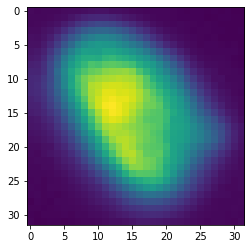

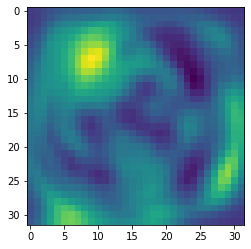

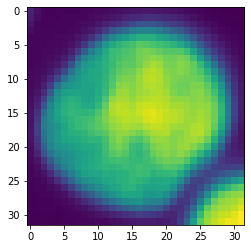

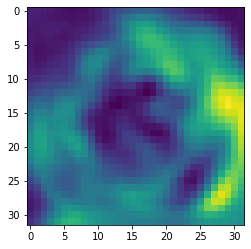

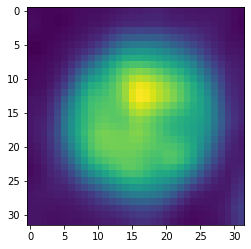

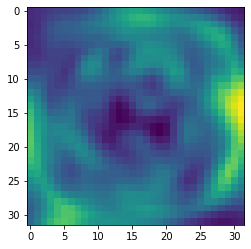

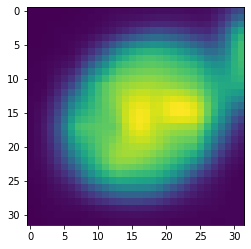

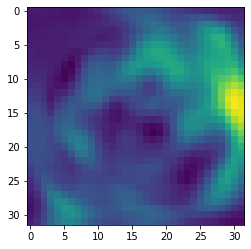

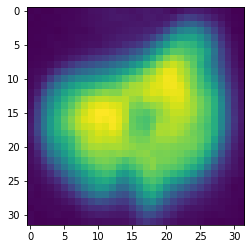

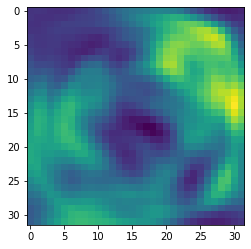

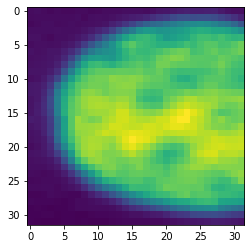

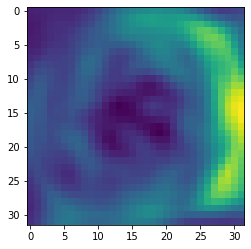

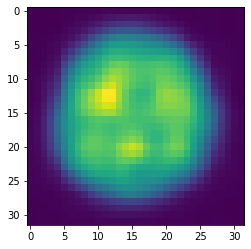

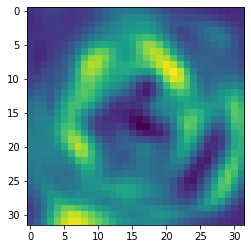

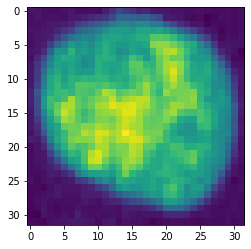

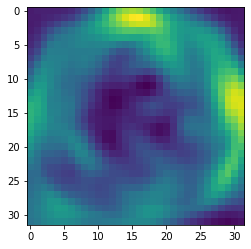

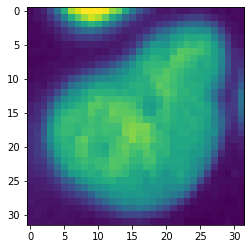

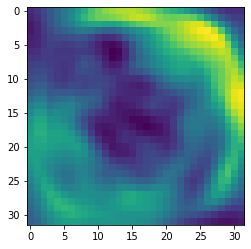

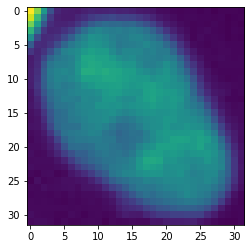

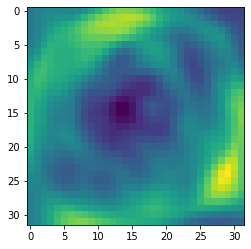

In [83]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [84]:
# Try it with less reguralization

In [86]:
vae2 = VAE_MNIST(512, 0.3, 1e-3)

In [88]:
AE2 = vae2.build_vae_keras_model()

In [89]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/reg_less'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE2.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3339/3339 [==============================] - ETA: 0s - loss: -1614.3038
Epoch 1: val_loss improved from inf to -1788.89734, saving model to ../models/reg_less
3339/3339 [==============================] - 46s 12ms/step - loss: -1614.3038 - val_loss: -1788.8973 - lr: 0.0010
Epoch 2/15
3336/3339 [============================>.] - ETA: 0s - loss: -2252.2781
Epoch 2: val_loss improved from -1788.89734 to -2127.36133, saving model to ../models/reg_less
3339/3339 [==============================] - 40s 12ms/step - loss: -2251.8562 - val_loss: -2127.3613 - lr: 0.0010
Epoch 3/15
3339/3339 [==============================] - ETA: 0s - loss: -2475.3555
Epoch 3: val_loss improved from -2127.36133 to -2351.27417, saving model to ../models/reg_less
3339/3339 [==============================] - 39s 12ms/step - loss: -2475.3555 - val_loss: -2351.2742 - lr: 0.0010
Epoch 4/15
3335/3339 [============================>.] - ETA: 0s - loss: -2583.5562
Epoch 4: val_loss improved from -2351.27417 to -2

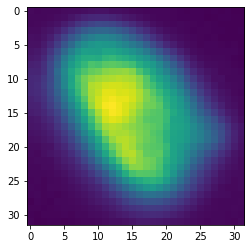

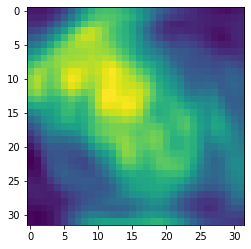

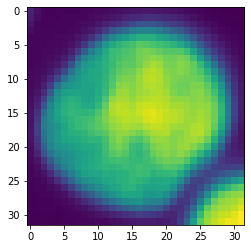

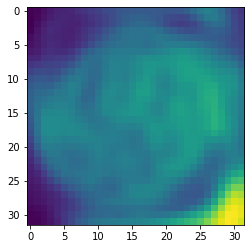

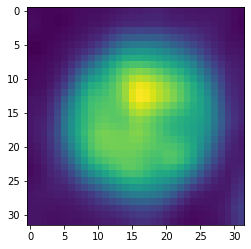

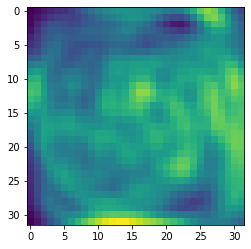

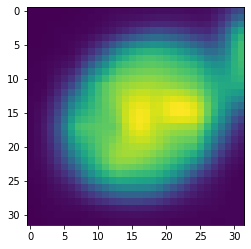

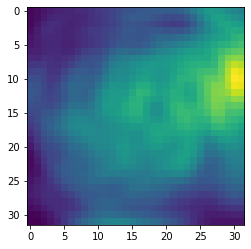

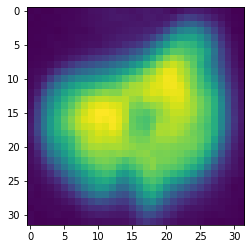

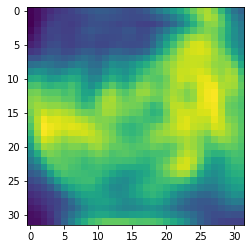

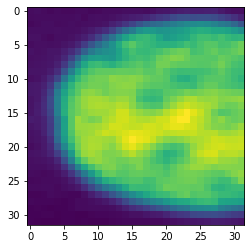

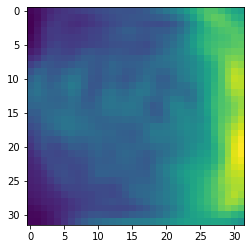

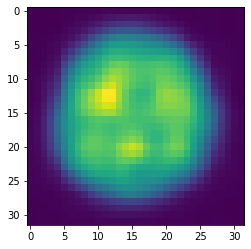

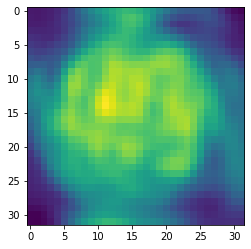

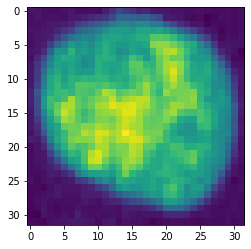

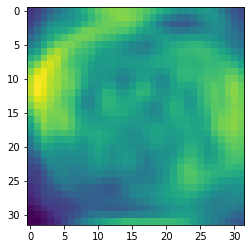

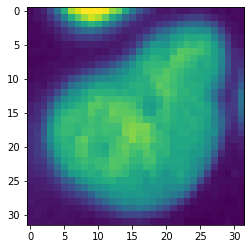

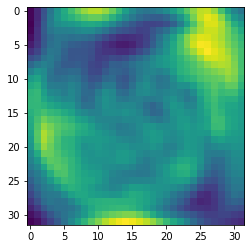

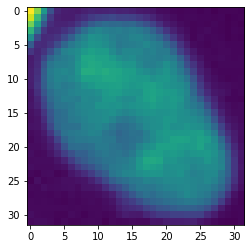

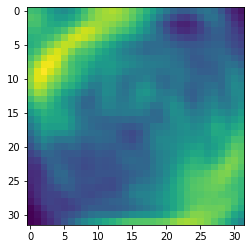

In [96]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE2(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [92]:
# Try with big (1024) embedding dim

In [93]:
vae3 = VAE_MNIST(1024, 1, 1e-3)

In [94]:
AE3 = vae3.build_vae_keras_model()

In [95]:
# Accidentally fit AE here instead of AE3
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/dim_1024'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3335/3339 [============================>.] - ETA: 0s - loss: -2630.4116
Epoch 1: val_loss improved from inf to -2447.58350, saving model to ../models/dim_1024
3339/3339 [==============================] - 40s 12ms/step - loss: -2629.3467 - val_loss: -2447.5835 - lr: 0.0010
Epoch 2/15
3336/3339 [============================>.] - ETA: 0s - loss: -2632.3005
Epoch 2: val_loss improved from -2447.58350 to -2469.07861, saving model to ../models/dim_1024
3339/3339 [==============================] - 40s 12ms/step - loss: -2631.6006 - val_loss: -2469.0786 - lr: 0.0010
Epoch 3/15
3339/3339 [==============================] - ETA: 0s - loss: -2645.1843
Epoch 3: val_loss improved from -2469.07861 to -2480.66870, saving model to ../models/dim_1024
3339/3339 [==============================] - 40s 12ms/step - loss: -2645.1843 - val_loss: -2480.6687 - lr: 0.0010
Epoch 4/15
3339/3339 [==============================] - ETA: 0s - loss: -2654.3755
Epoch 4: val_loss improved from -2480.66870 to -2

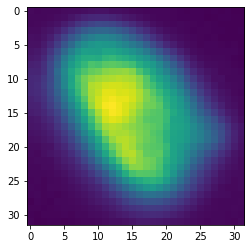

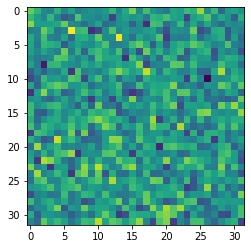

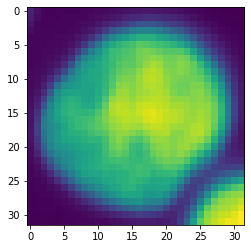

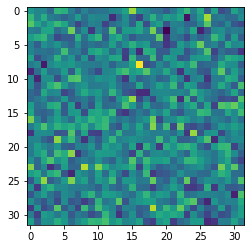

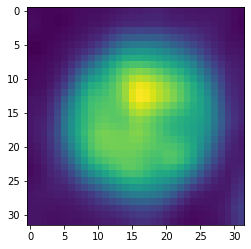

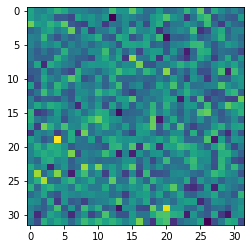

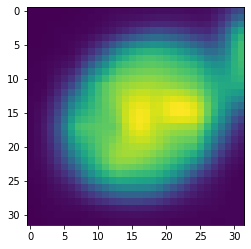

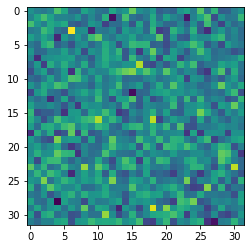

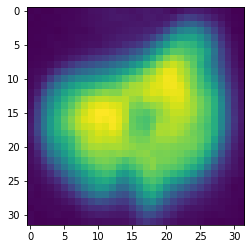

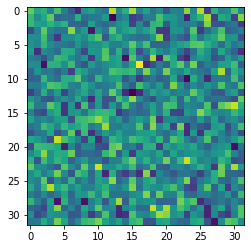

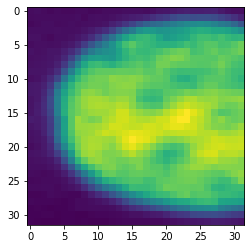

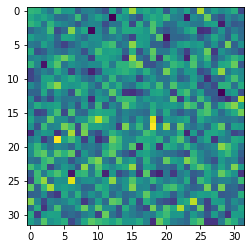

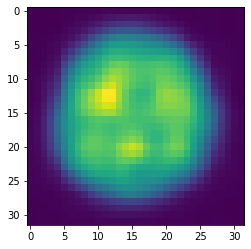

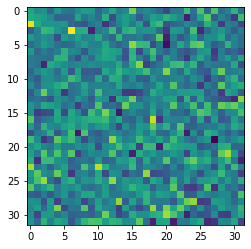

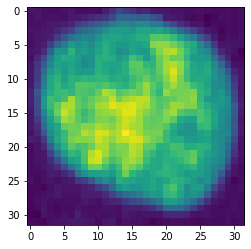

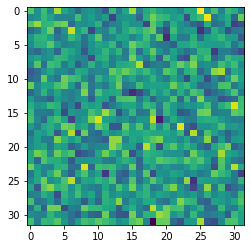

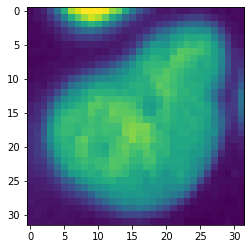

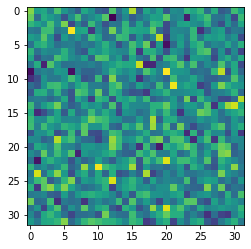

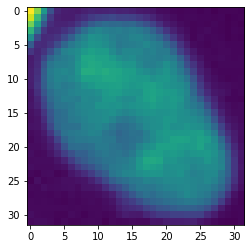

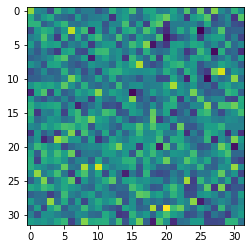

In [97]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE3(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [98]:
# Try with even less regularization

In [99]:
vae4 = VAE_MNIST(512, 0.1, 1e-3)

In [100]:
AE4 = vae4.build_vae_keras_model()

In [101]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/reg_very_low'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE4.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3335/3339 [============================>.] - ETA: 0s - loss: -1711.8394
Epoch 1: val_loss improved from inf to -1987.15735, saving model to ../models/reg_very_low
3339/3339 [==============================] - 42s 12ms/step - loss: -1711.7710 - val_loss: -1987.1573 - lr: 0.0010
Epoch 2/15
3336/3339 [============================>.] - ETA: 0s - loss: -2375.0256
Epoch 2: val_loss improved from -1987.15735 to -2301.90479, saving model to ../models/reg_very_low
3339/3339 [==============================] - 40s 12ms/step - loss: -2374.5688 - val_loss: -2301.9048 - lr: 0.0010
Epoch 3/15
3337/3339 [============================>.] - ETA: 0s - loss: -2606.1003
Epoch 3: val_loss improved from -2301.90479 to -2514.27856, saving model to ../models/reg_very_low
3339/3339 [==============================] - 40s 12ms/step - loss: -2605.8481 - val_loss: -2514.2786 - lr: 0.0010
Epoch 4/15
3339/3339 [==============================] - ETA: 0s - loss: -2730.5552
Epoch 4: val_loss improved from -2514

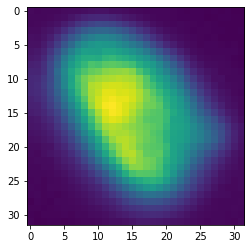

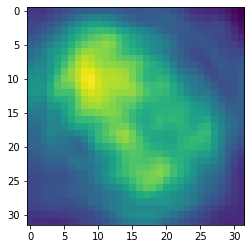

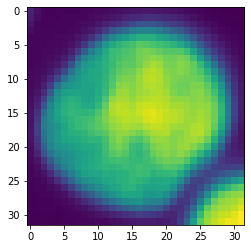

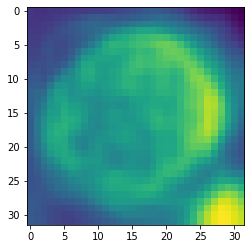

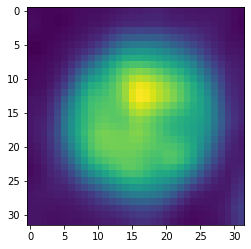

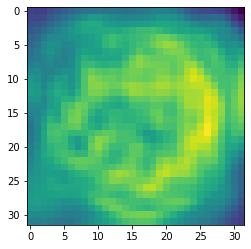

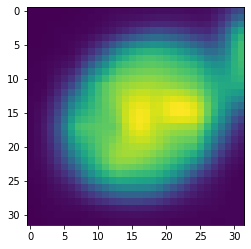

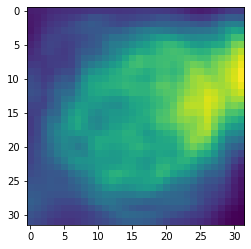

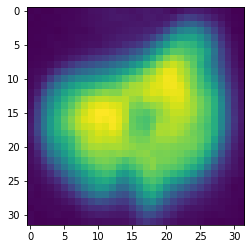

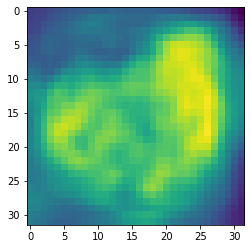

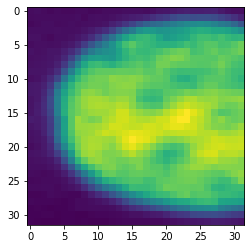

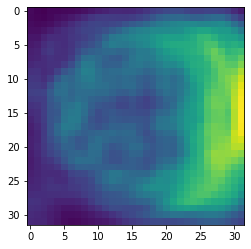

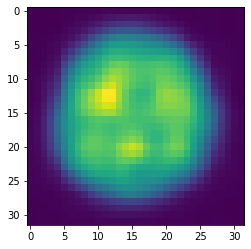

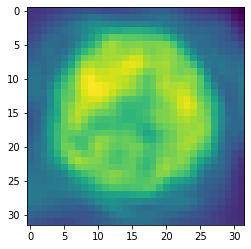

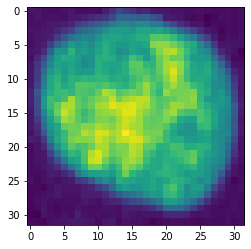

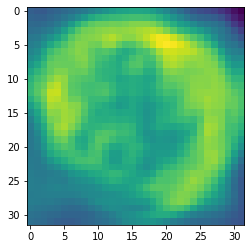

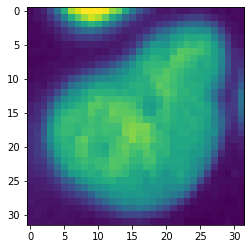

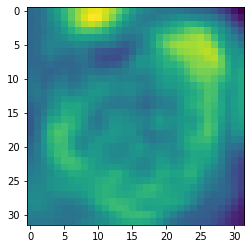

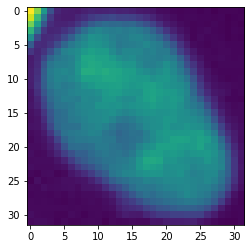

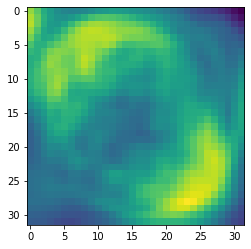

In [102]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE4(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [103]:
# Try it with no regularization

In [104]:
vae5 = VAE_MNIST(512, 0, 1e-3)

In [105]:
AE5 = vae5.build_vae_keras_model()

In [106]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/no_reg'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE4.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3336/3339 [============================>.] - ETA: 0s - loss: -3161.9954
Epoch 1: val_loss improved from inf to -3086.35645, saving model to ../models/no_reg
3339/3339 [==============================] - 40s 12ms/step - loss: -3161.1213 - val_loss: -3086.3564 - lr: 0.0010
Epoch 2/15
3339/3339 [==============================] - ETA: 0s - loss: -3227.9949
Epoch 2: val_loss improved from -3086.35645 to -3124.19238, saving model to ../models/no_reg
3339/3339 [==============================] - 40s 12ms/step - loss: -3227.9949 - val_loss: -3124.1924 - lr: 0.0010
Epoch 3/15
3335/3339 [============================>.] - ETA: 0s - loss: -3195.8711
Epoch 3: val_loss improved from -3124.19238 to -3124.98511, saving model to ../models/no_reg
3339/3339 [==============================] - 39s 12ms/step - loss: -3194.7920 - val_loss: -3124.9851 - lr: 0.0010
Epoch 4/15
3338/3339 [============================>.] - ETA: 0s - loss: -3248.2405
Epoch 4: val_loss improved from -3124.98511 to -3132.93

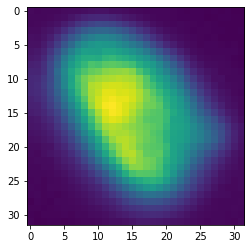

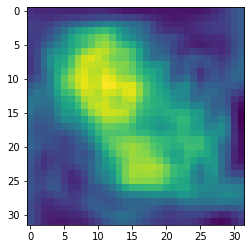

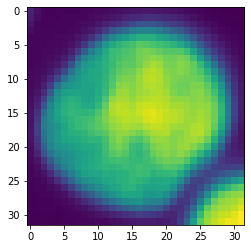

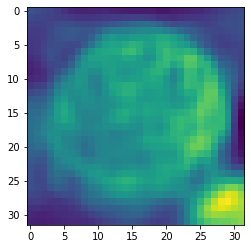

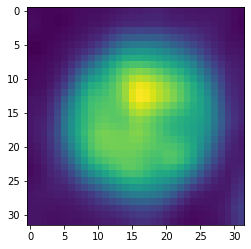

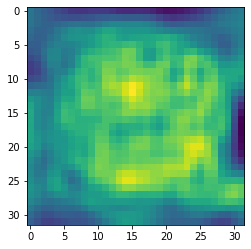

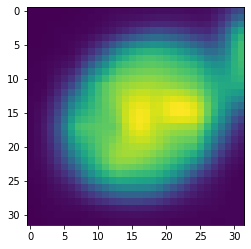

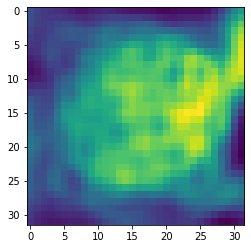

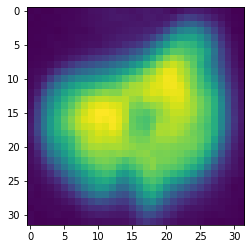

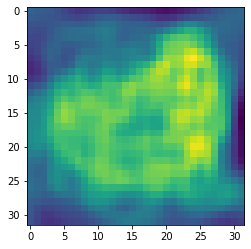

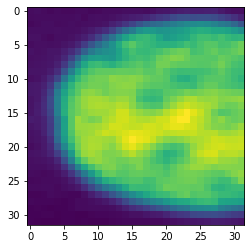

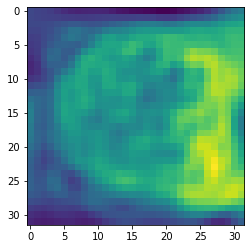

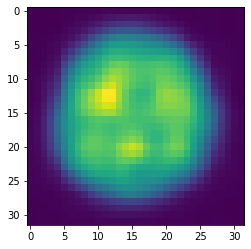

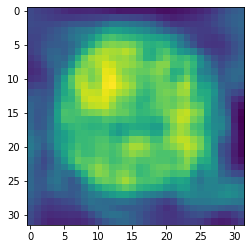

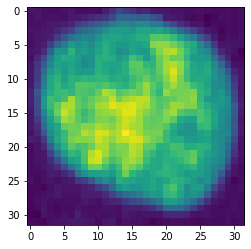

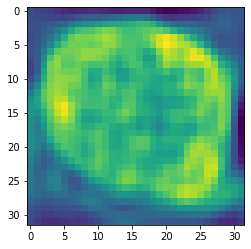

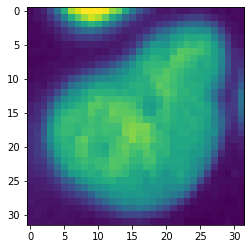

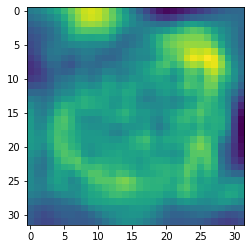

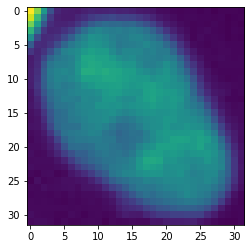

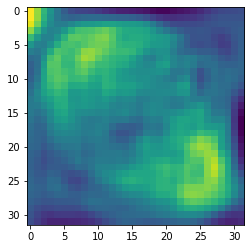

In [108]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE4(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [109]:
# Accidentally trained AE4 above, but recons not accurate since AE 4 had already been trained with reg

In [111]:
# Try to get embeddings maybe from AE2

In [ ]:
class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(8*8*32, activation=None))
        layers.append(tfkl.Reshape((8,8,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [117]:
encoder2 = vae2.encoder_z()

In [120]:
x = np.array([train_appearances[1324]])

In [121]:
x.shape

(1, 32, 32, 1)

In [124]:
# Clearly, the only argument is the VAE itself, so how can x be an argument?
z = encoder2(x)

In [125]:
z.shape

TensorShape([1, 512])

In [126]:
# We might want to return the distribution that the data is encoded as rather than a sample from it

In [127]:
from keras import backend as K

inp = encoder2.input
out = z_params.output
func = K.function([inp, K.learning_phase()], [out])

NameError: name 'z_params' is not defined

In [131]:
z_params = encoder2.get_layer('z_params')

In [133]:
from keras import backend as K

inp = encoder2.input
out = z_params.output
func = K.function([inp], [out])

In [134]:
z = func([x])

In [135]:
z.shape

AttributeError: 'list' object has no attribute 'shape'

In [136]:
len(z)

1

In [137]:
z[0].shape

(1, 1024)

In [138]:
z[0][0].shape

(1024,)

In [192]:
type(z[0][0])

numpy.ndarray

In [139]:
print(z[0][0])

[-689.9399   607.9933  -473.07782 ... -248.41951  675.8818  -563.3669 ]


In [140]:
type(z[0][0])

numpy.ndarray

# Get embeddings (encoded distributions, not samples)

In [141]:
# We want to be able to get the frame of an image in the pruned dataset. We have get_real_idx which gets the index
# in the pruned array based on the batch, frame, and cell, but we need to invert that, basically

In [142]:
# Gets index of non-blank image (from original array) in (pruned) array of non-blank images
def get_real_idx(batch, frame, cell):
    assert (cell in real_img_nums_dict[batch].keys() and frame < real_img_nums_dict[batch][cell]), "Blank image"
    idx = 0
    for b in range(batch):
        idx += sum(real_img_nums_dict[b].values())
    for c in range(cell):
        idx += real_img_nums_dict[batch][c]
    idx += frame
    return idx

In [152]:
real_img_nums_dict = get_real_img_nums_dict(train_track_info['appearances'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [146]:
print("hello")

hello


In [168]:
def get_original_pos(real_idx):
    img_num = real_idx + 1
    batch = 0
    cell = 0
    frame = 0
    
    imgs_seen = 0
    for b in real_img_nums_dict.keys():
        imgs_will_see = imgs_seen + sum(real_img_nums_dict[b].values())
        if imgs_will_see >= img_num:
            batch = b
            break
        else:
            imgs_seen = imgs_will_see
    for c in real_img_nums_dict[batch].keys():
        imgs_will_see = imgs_seen + real_img_nums_dict[batch][c]
        if imgs_will_see >= img_num:
            cell = c
            break
        else:
            imgs_seen = imgs_will_see
    imgs_left = img_num - imgs_seen
    frame = imgs_left - 1
    
    return (batch, cell, frame)

In [154]:
real_img_nums_dict

{0: {0: 50,
  1: 50,
  2: 12,
  3: 50,
  4: 50,
  5: 43,
  6: 50,
  7: 43,
  8: 50,
  9: 50,
  10: 50,
  11: 50,
  12: 50,
  13: 50,
  14: 50,
  15: 50,
  16: 50,
  17: 50,
  18: 50,
  19: 26,
  20: 34},
 1: {0: 23,
  1: 50,
  2: 50,
  3: 50,
  4: 50,
  5: 50,
  6: 50,
  7: 50,
  8: 50,
  9: 50,
  10: 50,
  11: 50,
  12: 50,
  13: 38,
  14: 49},
 2: {0: 50, 1: 50, 2: 50, 3: 50, 4: 50},
 3: {0: 3,
  1: 50,
  2: 27,
  3: 50,
  4: 50,
  5: 50,
  6: 50,
  7: 2,
  8: 2,
  9: 50,
  10: 50,
  11: 50},
 4: {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 18},
 5: {0: 7,
  1: 6,
  2: 21,
  3: 12,
  4: 34,
  5: 5,
  6: 65,
  7: 65,
  8: 65,
  9: 63,
  10: 39,
  11: 39,
  12: 65,
  13: 53,
  14: 54,
  15: 65,
  16: 65,
  17: 41,
  18: 7,
  19: 65,
  20: 65,
  21: 50,
  22: 65,
  23: 65,
  24: 65,
  25: 65,
  26: 65,
  27: 46,
  28: 65,
  29: 65,
  30: 65,
  31: 62,
  32: 65,
  33: 65,
  34: 65,
  35: 65,
  36: 65,
  37: 3,
  38: 49,
  39: 5,
  40: 39,
  41: 65,
  42: 65,
  43: 65,
  44: 65,
  45: 65,
  46:

In [156]:
train_appearances.shape

(333854, 32, 32, 1)

In [159]:
get_original_pos(0)

(0, 0, 0)

In [161]:
get_original_pos(1)

(0, 0, 1)

In [162]:
get_original_pos(51)

(0, 0, 51)

In [169]:
get_original_pos(60)

(0, 1, 10)

In [170]:
get_original_pos(120)

(0, 3, 8)

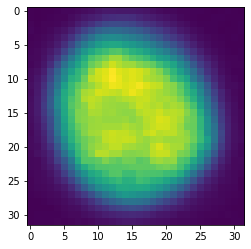

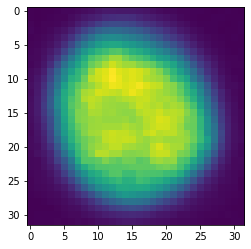

In [172]:
import matplotlib.pyplot as plt

idx = 120
batch, frame, cell = get_original_pos(idx)

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

fig, ax = plt.subplots()
ax.imshow(train_appearances[get_real_idx(batch, frame, cell)])

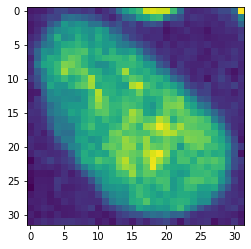

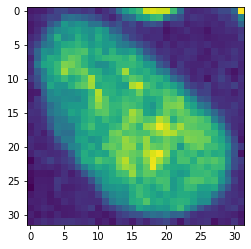

In [184]:
idx = 322344
batch, cell, frame = get_original_pos(idx)

fig, ax = plt.subplots()
ax.imshow(train_track_info['appearances'][batch][frame][cell])

fig, ax = plt.subplots()
ax.imshow(train_appearances[idx])

In [180]:
train_track_info['appearances'].shape

(91, 71, 405, 32, 32, 1)

In [189]:
# Gets dictionary where keys are image indices and values are frames corresponding with image for train_appearances
# or val_appearances arrays
def get_frame_dict(app):
    frame_dict = {}
    for idx in range(app.shape[0]):
        frame_dict[idx] = get_original_pos(idx)[2]
    return frame_dict

In [190]:
# We're doing this in O(n^2) time when it should be O(n), but it almost certainly doesn't matter
%%time
train_frame_dict = get_frame_dict(train_appearances)

CPU times: user 22.4 s, sys: 0 ns, total: 22.4 s
Wall time: 22.4 s


In [191]:
val_frame_dict = get_frame_dict(val_appearances)

In [203]:
import pandas as pd

def get_embedding_distr(img, encoder):
    z_params = encoder.get_layer('z_params')
    inp = encoder.input
    out = z_params.output
    func = K.function([inp], [out])
    x = np.array([img])
    z = func([x])
    return z[0][0]

# Gets embeddings of each array (train, val) along with frame classes
def get_embeddings_df(app, encoder, embedding_dim):
    frame_dict = get_frame_dict(app)
    
    embeddings_lst = []
    for idx in range(app.shape[0]):
        img = app[idx]
        embedding_distr = get_embedding_distr(img, encoder)
        frame = frame_dict[idx]
        embeddings_lst.append(np.append(embedding_distr, frame))
    
    cols = [idx for idx in range(2 * embedding_dim)]
    cols.append('Frame')
    embeddings_df = pd.DataFrame(embeddings_lst, columns=cols)
    return embeddings_df

In [204]:
embeddings_df = get_embeddings_df(train_appearances, encoder2, 512)

In [207]:
embeddings_df[0:3]

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Frame
0,-149.726028,360.962738,-194.467590,-96.283844,87.604736,209.856476,-183.187012,-100.659630,124.342598,36.089905,...,465.676025,-167.349991,312.675995,5.308479,191.939911,-30.311768,-197.808426,217.123474,-130.322845,0.0
1,-226.960022,385.638062,-117.022568,-133.413574,89.235138,281.667847,-214.646210,-93.154457,129.248383,56.768509,...,496.059265,-151.521454,185.428253,-66.273010,203.216446,7.056793,-244.498962,270.605286,-177.964417,1.0
2,-236.985764,396.134979,-164.722977,-165.193909,140.753784,246.607727,-230.603699,-124.592957,122.197784,5.958461,...,465.613647,-144.137817,292.382141,-92.875015,213.640427,23.800011,-189.153885,256.146973,-173.831390,2.0


In [209]:
cols = [idx for idx in range(2 * 512)]
cols.append('Frame')
embeddings_df.to_csv('../embeddings/reg_3_embeddings.csv', header=cols)

In [211]:
def project_embeddings_tsne(embeddings_df, tsne):
    just_embeddings_df = embeddings_df.drop('Frame', axis=1)
    neighbors_embeddings = tsne.fit_transform(just_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, embeddings_df[['Frame']]], axis = 1)
                          
    return final_df

In [212]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [213]:
%%time
embeddings_tsne_df = project_embeddings_tsne(embeddings_df, tsne)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 10h 14min 10s, sys: 0 ns, total: 10h 14min 10s
Wall time: 36min 46s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


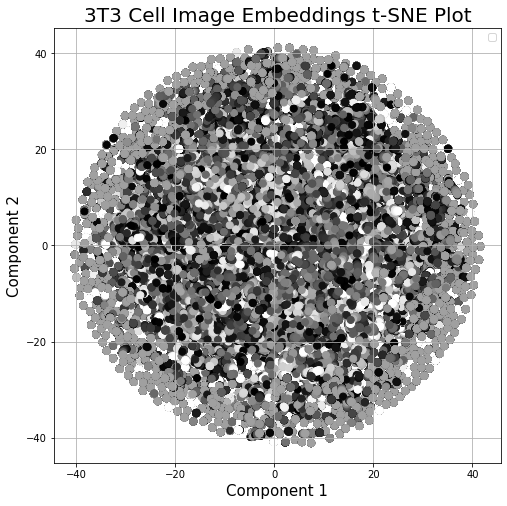

In [215]:
import matplotlib.pyplot as plt

colors = []
for time in embeddings_tsne_df['Frame']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('3T3 Cell Image Embeddings t-SNE Plot', fontsize = 20)
ax.scatter(embeddings_tsne_df['component 1'], embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [216]:
# Load weights from no_reg

In [218]:
vae_load = VAE_MNIST(512, 0.1, 1e-3)
AE_load = vae_load.build_vae_keras_model()
AE_load.load_weights('../models/reg_very_low')

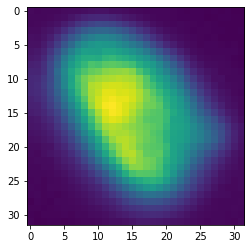

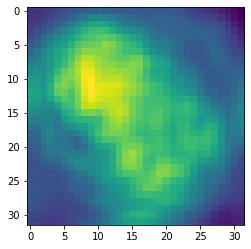

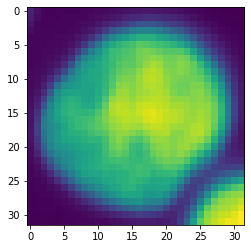

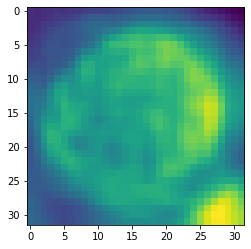

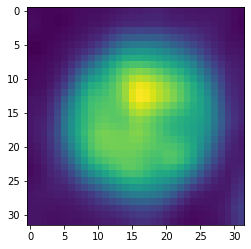

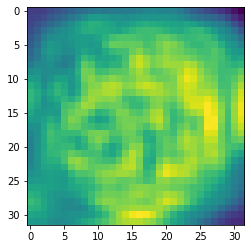

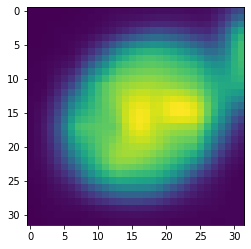

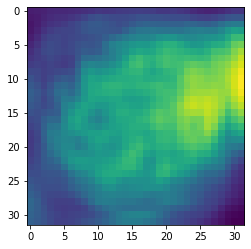

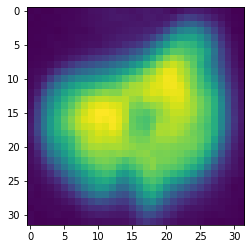

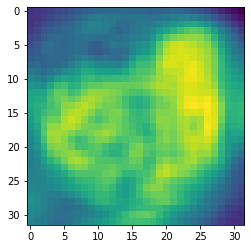

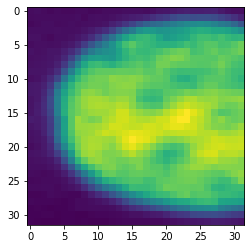

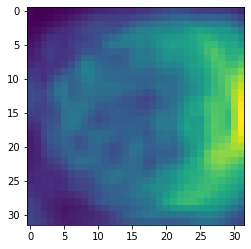

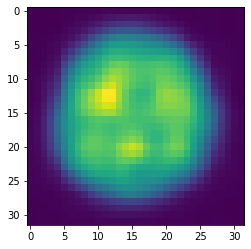

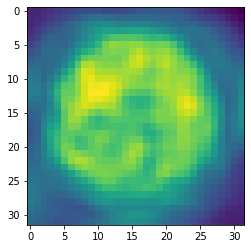

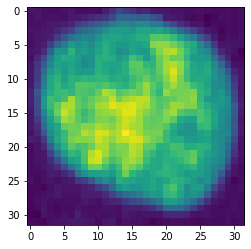

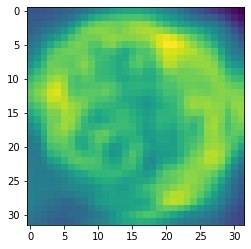

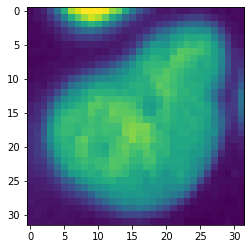

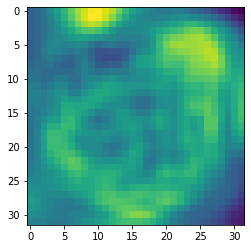

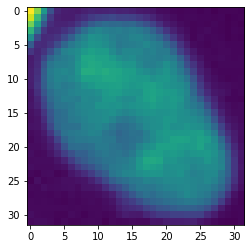

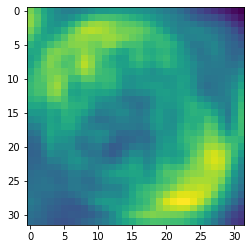

In [219]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE_load(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])